In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras

In [2]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=6)
  plt.grid=True

def trend(time, slope):
  return time*slope

def seasonal_pattern(seasonal_time):
  return np.where(seasonal_time<0.4,
                  np.cos(seasonal_time*2*np.pi),
                  1/np.exp(3*seasonal_time))
  
def seasonality(time, period, amplitude=1, phase=0):
  seasonal_time = ((time+phase)%period)/period
  return amplitude*seasonal_pattern(seasonal_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

def sequential_window_dataset(series, window_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=window_size, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.map(lambda window: (window[:-1], window[-1]))
  return ds.batch(1).prefetch(1)

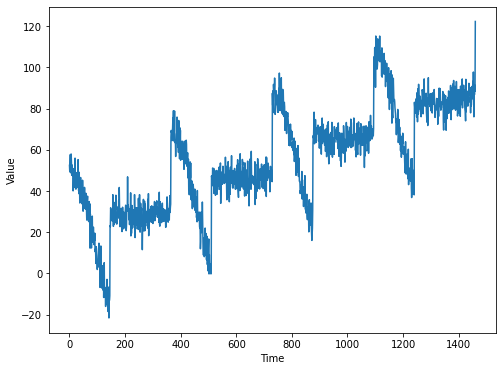

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(8,6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=30
train_set = sequential_window_dataset(x_train, window_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
                                    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*200.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
reset_states = ResetStatesCallback()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 13s 61ms/step - loss: 88.4565 - mae: 88.9564 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 20ms/step - loss: 81.4348 - mae: 81.9347 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 73.0338 - mae: 73.5338 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 63.6034 - mae: 64.1034 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 19ms/step - loss: 53.0491 - mae: 53.5488 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 41.2625 - mae: 41.7621 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 28.2579 - mae: 28.7558 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 14ms/step - loss: 15.8443 - mae: 16.3413 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 14ms/step - loss: 10.7209 - mae

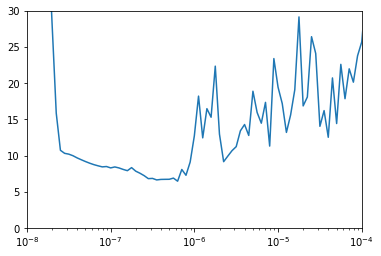

In [9]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(100, batch_input_shape=[1, None, 1], return_sequences=True, stateful=True),
                                    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x*200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
reset_state = ResetStatesCallback()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint, reset_state])

Epoch 1/500
33/33 [==============================] - 5s 49ms/step - loss: 69.3871 - mae: 69.8871 - val_loss: 69.4903 - val_mae: 69.9903
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 13.2583 - mae: 13.7554 - val_loss: 14.5565 - val_mae: 15.0418
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 17.1715 - mae: 17.6641 - val_loss: 26.5782 - val_mae: 27.0710
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 9.8101 - mae: 10.2931 - val_loss: 16.3970 - val_mae: 16.8970
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 12.0507 - mae: 12.5463 - val_loss: 19.5185 - val_mae: 20.0185
Epoch 6/500
33/33 [==============================] - 1s 18ms/step - loss: 8.8731 - mae: 9.3598 - val_loss: 15.4617 - val_mae: 15.9617
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - loss: 9.2740 - mae: 9.7605 - val_loss: 16.4960 - val_mae: 16.9960
Epoch 8/500
33/33 [==============================] - 

In [18]:
model = tf.keras.models.load_model('model_checkpoint.h5')

In [19]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time-1:-1, 0]

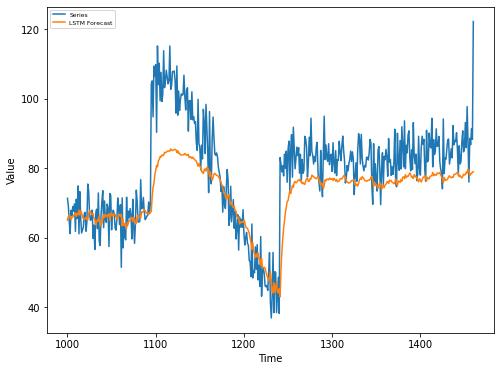

In [20]:
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, rnn_forecast, label='LSTM Forecast')
plt.show()

In [21]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.9462733